<a href="https://colab.research.google.com/github/Yodai1996/CV/blob/master/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [325]:
!pip install torch torchvision

import torch
torch.cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input and output

もうちょい画素数多い鮮明な画像を使ってもいい。

In [0]:
FILE_NAME  = "./sample_data/mnist_train_small.csv"
FILE_NAME2 = "./sample_data/mnist_test.csv"

num_epoch = 2000

In [0]:
label_one_data   = []
label_four_data  = []
label_seven_data = []

with open(FILE_NAME) as f:
  reader = csv.reader(f)
  for row in reader:
    label = row[0]
    if label=="1":
      label_one_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "4":
      label_four_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "7":
      label_seven_data.append([float(elem)/255 for elem in row[1:]])
      
with open(FILE_NAME2) as g:
  reader = csv.reader(g)
  for row in reader:
    label = row[0]
    if label=="1":
      label_one_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "4":
      label_four_data.append([float(elem)/255 for elem in row[1:]])
    elif label == "7":
      label_seven_data.append([float(elem)/255 for elem in row[1:]])

In [0]:
label_one_data = np.array(label_one_data)
label_four_data = np.array(label_four_data)
label_seven_data = np.array(label_seven_data)

In [329]:
label_one_data.shape

(3378, 784)

とりあえず表示させてみる

In [0]:
l = label_one_data

In [0]:
size=l.shape[0]
new_l = l.reshape([size, 28, 28])

In [332]:
new_l.shape

(3378, 28, 28)

In [333]:
new_l[0][0][0].dtype

dtype('float64')

In [334]:
new_l[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

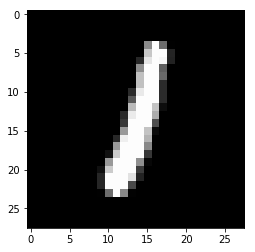

In [335]:
fig, ax = plt.subplots()
ax.imshow(new_l[-1], cmap="gray")
plt.show()

VAEのモデルを定義する

In [0]:
#define a model of VAE
class VAE(nn.Module):
  
  def __init__(self, dim=500 ,latent_dim=20):
    super(VAE, self).__init__()    
    self.en_dense1 = nn.Linear(28*28, dim)
    self.en_dense2 = nn.Linear(dim, dim)
    self.mean   = nn.Linear(dim, latent_dim)
    self.var    = nn.Linear(dim, latent_dim)    
    self.de_dense1 = nn.Linear(latent_dim, dim)
    self.de_dense2 = nn.Linear(dim, dim)
    self.de_dense3 = nn.Linear(dim, 28*28)
    
  def _encoder(self, x):
    x    = F.relu(self.en_dense1(x))
    x    = F.relu(self.en_dense2(x))
    mean = self.mean(x)
    var  = F.softplus(self.var(x)) #variance should be always non-negative
    return mean, var  
  
  def _hidden_sampling(self, mean, var): #無相関と仮定
    eps = torch.randn(mean.shape).to(device)
    return mean + torch.sqrt(var)*eps
  
  def _decoder(self, z):
    x = F.relu(self.de_dense1(z))
    x = F.relu(self.de_dense2(x))    
    x = F.relu(self.de_dense3(x))    
    x = F.sigmoid(x)  #limit the output in [0,1]
    return x    
  
  
  def forward(self, x): 
    mean, var = self._encoder(x)
    z = self._hidden_sampling(mean, var)
    y = self._decoder(z)
    return y, z
  
  
  def loss(self, x): 
    mean, var = self._encoder(x)
    kl = -0.5 *  torch.mean(torch.sum(1+torch.log(var) - mean**2 - var)) #無相関ver
    z  = self._hidden_sampling(mean, var)
    y  = self._decoder(z)
    reconstruct = torch.mean(torch.sum(x * torch.log(y) + (1-x) * torch.log(1-y)))     #y is [0,1] so non-negative, so log make sense. 
    return -(reconstruct - kl) 

In [337]:
l.shape

(3378, 784)

In [338]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

for i in range(num_epoch):
  losses = []
  x = torch.tensor(l, dtype=torch.float, device=device) # instead of new_l
  model.zero_grad()
  y = model(x)
  loss = model.loss(x)
 # print(loss)
  loss.backward()
  optimizer.step()
  losses.append(loss.cpu().detach().numpy())
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 0 loss: 1881844.5
EPOCH: 1 loss: 1851257.75
EPOCH: 2 loss: 1841173.875
EPOCH: 3 loss: 1836520.25
EPOCH: 4 loss: 1833641.25
EPOCH: 5 loss: 1831291.5
EPOCH: 6 loss: 1828882.0
EPOCH: 7 loss: 1826406.75
EPOCH: 8 loss: 1824028.75
EPOCH: 9 loss: 1821985.5
EPOCH: 10 loss: 1820779.75
EPOCH: 11 loss: 1820177.5
EPOCH: 12 loss: 1820294.375
EPOCH: 13 loss: 1820381.125
EPOCH: 14 loss: 1820424.625
EPOCH: 15 loss: 1819817.375
EPOCH: 16 loss: 1819440.375
EPOCH: 17 loss: 1819255.625
EPOCH: 18 loss: 1819228.75
EPOCH: 19 loss: 1819063.625
EPOCH: 20 loss: 1819030.625
EPOCH: 21 loss: 1819087.25
EPOCH: 22 loss: 1818855.0
EPOCH: 23 loss: 1818833.0
EPOCH: 24 loss: 1818597.125
EPOCH: 25 loss: 1818499.5
EPOCH: 26 loss: 1818485.0
EPOCH: 27 loss: 1818285.5
EPOCH: 28 loss: 1818333.125
EPOCH: 29 loss: 1818333.125
EPOCH: 30 loss: 1818277.125
EPOCH: 31 loss: 1818171.75
EPOCH: 32 loss: 1818264.625
EPOCH: 33 loss: 1818170.625
EPOCH: 34 loss: 1818237.0
EPOCH: 35 loss: 1818169.5
EPOCH: 36 loss: 1818156.75
EPOCH: 3

sampling

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


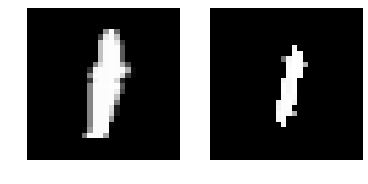

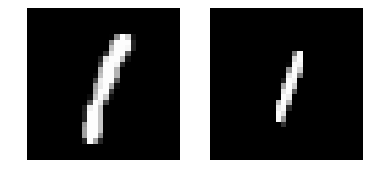

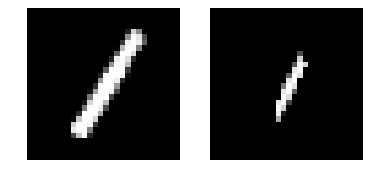

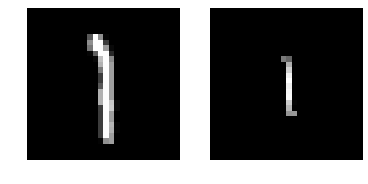

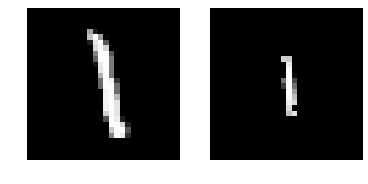

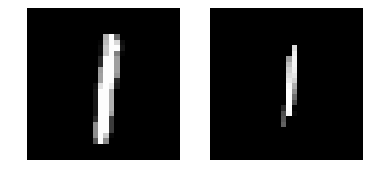

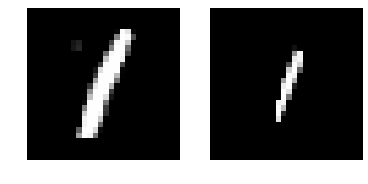

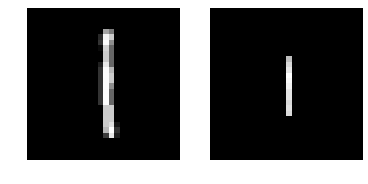

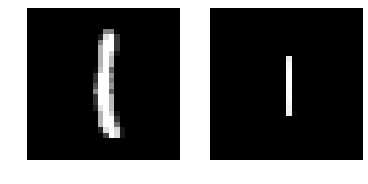

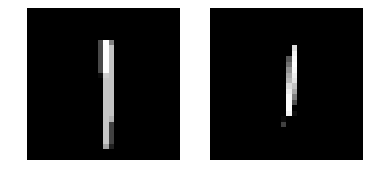

In [371]:
#sampling
x = torch.tensor(l, dtype=torch.float, device=device) # instead of new_l
y, z = model(x)
y = y.cpu().detach().numpy()

size=l.shape[0]
new_x = l.reshape([size, 28, 28])
new_y = y.reshape([size, 28, 28])

for i in range(10):
  fig, axes = plt.subplots(1, 2)
  axes[0].set_axis_off()
  axes[0].imshow(new_x[i], cmap="gray")

  axes[1].set_axis_off()
  axes[1].imshow(new_y[i], cmap="gray")

  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


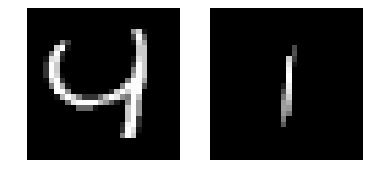

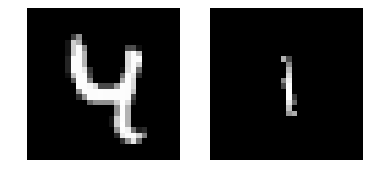

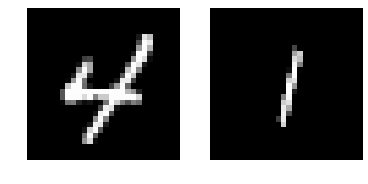

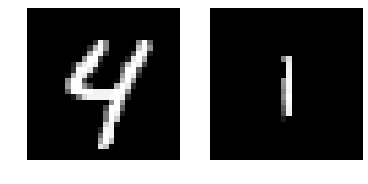

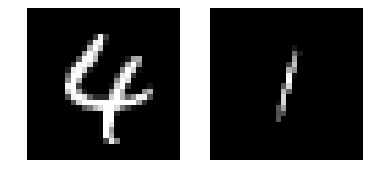

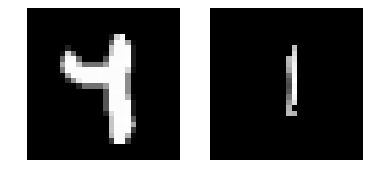

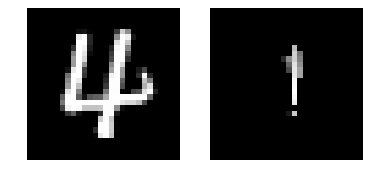

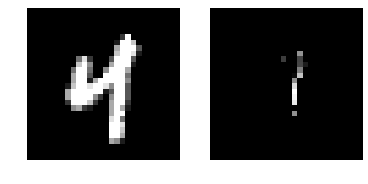

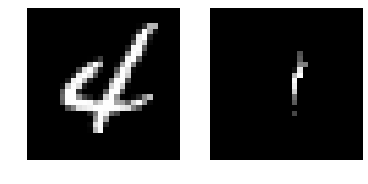

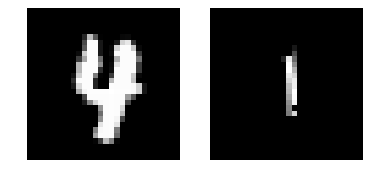

In [369]:
#experiments
four = torch.tensor(label_four_data, dtype=torch.float, device=device) # instead of new_l
y, z = model(four)
y = y.cpu().detach().numpy()

four_size = label_four_data.shape[0]
inputs  = label_four_data.reshape([four_size, 28, 28])
outputs = y.reshape([four_size, 28, 28])

for i in range(10):
  fig, axes = plt.subplots(1, 2)
  axes[0].set_axis_off()
  axes[0].imshow(inputs[i], cmap="gray")

  axes[1].set_axis_off()
  axes[1].imshow(outputs[i], cmap="gray")

  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


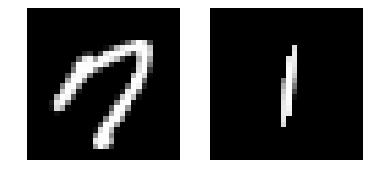

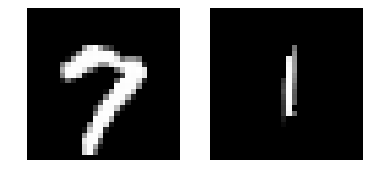

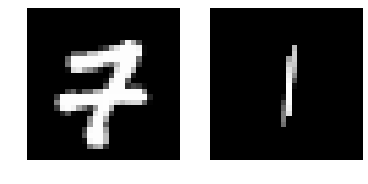

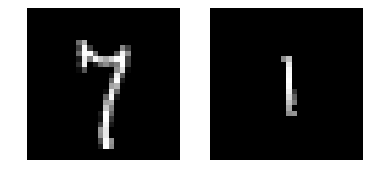

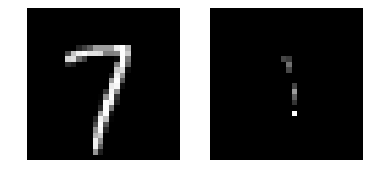

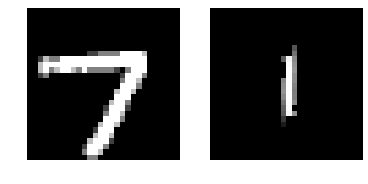

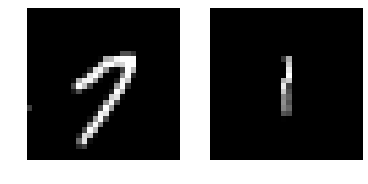

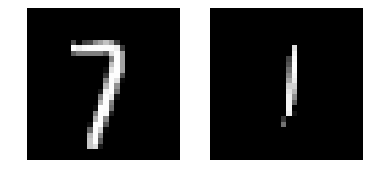

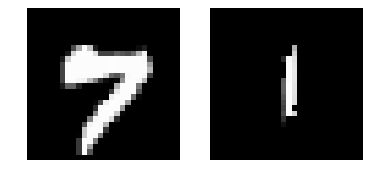

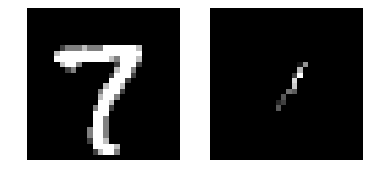

In [370]:
#experiments
seven = torch.tensor(label_seven_data, dtype=torch.float, device=device) # instead of new_l
y, z = model(seven)
y = y.cpu().detach().numpy()

seven_size = label_seven_data.shape[0]
inputs  = label_seven_data.reshape([seven_size, 28, 28])
outputs = y.reshape([seven_size, 28, 28])

for i in range(10):
  fig, axes = plt.subplots(1, 2)
  axes[0].set_axis_off()
  axes[0].imshow(inputs[i], cmap="gray")

  axes[1].set_axis_off()
  axes[1].imshow(outputs[i], cmap="gray")

  plt.show()

結論：

「１」だけを用いてVAEで学習。

この学習器に対し、「４」や「７」を入力しても、「１」のような形が生成された。

すなわち、未知の形状の入力に対しては、それを再現するように出力が生成されるというよりかは、

今まで学習した範囲内で生成尤度の高そうなものが生成されたということ。